In [6]:
import torch
from torch_geometric.data import Data, DataLoader, Dataset
import torch.nn.functional as F
import random 
import networkx as nx
import numpy as np
from torch_geometric.nn import NNConv
from torch.nn import Linear
from matplotlib import pyplot as plt
import torch.nn as nn
import glob
import random

In [68]:
#generate random graph
ngraph = 1000
ngraph_size = [random.randint(20,40) for i in range(ngraph)]
data_list = []
for i in range(ngraph):
    G, data = generate_graph(ngraph_size[i])
    data_list.append(data)

In [2]:
torch.cuda.is_available()

True

In [1]:
def generate_polygon(n, radius=1):
    node_pos = [(radius * np.cos(2 * np.pi * i / n),
                 radius * np.sin(2 * np.pi * i / n)) for i in range(n)]
    x = torch.tensor(node_pos,dtype=torch.float)
    return x

def generate_randPos(n, radius=1):
    node_pos = [(random.uniform(-1, 1),
                 random.uniform(-1, 1)) for i in range(n)]
    x = torch.tensor(node_pos,dtype=torch.float)
    return x

def generate_edgelist(size):
    edge_list = []
    for i in range(size):
        for j in range(size):
#             p = random.random()
#             if p > 0.5:
#                 edge_list.append((i,j))
#             else:
#                 edge_list.append((j,i))  
            if i != j:
                edge_list.append((i,j))
    return edge_list

def node2edge(node_pos, batch):
    # find sizes for each graph in batch
    graph_sizes = list(map(lambda d: d.x.size()[0], batch.to_data_list()))
    # get split indices
    start_idx = np.insert(np.cumsum(graph_sizes), 0, 0)
    start_pos = []
    end_pos = []
    for i, num_nodes in enumerate(graph_sizes):
        # get edge list for current graph
        edgelist = np.array(generate_edgelist(num_nodes))
        # get node positions for current graph
        graph_node_pos = node_pos[start_idx[i]:start_idx[i+1]]
        # get edge start positions for current graph
        start_pos += [graph_node_pos[edgelist[:, 0]]]
        # get edge end positions for current graph
        end_pos += [graph_node_pos[edgelist[:, 1]]]
    # concatenate the results
    return torch.cat(start_pos, 0), torch.cat(end_pos, 0)

def generate_eAttr(G, com_edge_list):
    path_length = dict(nx.all_pairs_shortest_path_length(G))
    max_length = 0
    for source in path_length:
        for target in path_length[source]:
            if path_length[source][target] > max_length:
                max_length = path_length[source][target]
    L = 2/max_length
    K = 1
    edge_attr = []
    for i in com_edge_list:
        start = "n" + str(i[0])
        end = "n" + str(i[1])
        d = path_length[start][end]
        l = L * d #l = L * d
        k = K/(d**2) 
        start_degree = G.degree(start)
#         end_degree = G.degree(end)
        edge_attr.append([l,k])
    out = torch.tensor(edge_attr, dtype=torch.float)
    return out

def generate_graph(size):
    while True:
        G = nx.binomial_graph(size, random.uniform(0,0.2),directed=False)
#         G = nx.random_powerlaw_tree(size,3,tries=10000)
        com_edge_list = generate_edgelist(size)
        try:
            edge_attr = generate_eAttr(G, com_edge_list)
        except KeyError:
            continue
        except ZeroDivisionError:
            continue
#         nx.write_edgelist(G, file_name, data=False)
        edge_index = torch.tensor(com_edge_list, dtype=torch.long)
        x = generate_randPos(size)
        data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)
        return G, data

def generate_testgraph(size,prob):
    while True:
        G = nx.binomial_graph(size, prob,directed=False)
#         G = nx.random_powerlaw_tree(size,3,tries=10000)
        com_edge_list = generate_edgelist(size)
        try:
            edge_attr = generate_eAttr(G, com_edge_list)
        except KeyError:
            continue
        except ZeroDivisionError:
            continue
#         nx.write_edgelist(G, file_name, data=False)
        edge_index = torch.tensor(com_edge_list, dtype=torch.long)
        x = generate_randPos(size)
        data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)
        return G, data

class EnergyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data_batch):
        energy = 0
        offset = 0
        for data in data_batch.to_data_list():
            edge_attr = data.edge_attr
            n = data.x.size()[0]
            x = p[offset:offset+n, 0]
            y = p[offset:offset+n, 1]
            offset += n
            l = edge_attr[:, 0]
            k = edge_attr[:, 1]
            for e, (i, j) in enumerate(generate_edgelist(n)):
                term1 = (x[i] - x[j]) ** 2
                term2 = (y[i] - y[j]) ** 2
                term3 = l[e] ** 2
                term4 = 2 * l[e] * (term1 + term2).sqrt()
                energy += k[e] / 2 * (term1 + term2 + term3 - term4)
        return energy

    
class EnergyLossVectorized(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data):
        edge_attr = data.edge_attr
        # convert per-node positions to per-edge positions
        start, end = node2edge(p, data)
        
        start_x = start[:, 0]
        start_y = start[:, 1]
        end_x = end[:, 0]
        end_y = end[:, 1]
        
        l = edge_attr[:, 0]
        k = edge_attr[:, 1]
        
        term1 = (start_x - end_x) ** 2
        term2 = (start_y - end_y) ** 2
        term3 = l ** 2
        term4 = 2 * l * (term1 + term2).sqrt()
        energy = k / 2 * (term1 + term2 + term3 - term4)
        return energy.sum()/2
    
def train(model, criterion, optimizer,loader,data_list):
    model.train()
    loss_all = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,data)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(data_list)

def evaluate(model,data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        pred = model(data).detach().cpu().numpy()
    return pred

def load_rome(ngraph):
    files = glob.glob('../rome/*.graphml')
    random.shuffle(files)
    G_list = []
    count = 0
    for file in files:
        G = nx.read_graphml(file)
        G_list.append(G)
    return G_list

def graph_vis(G, node_pos, file_name):
    i = 0
    for n, p in node_pos:
        node = 'n' +str(i)
        G.nodes[node]['pos'] = (n,p)
        i += 1
    pos = nx.get_node_attributes(G,'pos')
    plt.figure()
    nx.draw(G, pos)
    plt.savefig(file_name) 
    
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = NNConv(2, 16, Linear(2,2*16),aggr='mean')
        self.conv2 = NNConv(16, 16, Linear(2, 16*16),aggr='mean')
        self.conv3 = NNConv(4*16, 2, Linear(2, 4*16*2),aggr='mean')
        self.relu = nn.LeakyReLU()
#         self.conv4 = NNConv(16+32+64, 128, Linear(2, (16+32+64)*128))
#         self.conv5 = NNConv(128,2,Linear(2,128*2))
#         self.conv2 = NNConv(16,2,Linear(2,16*2))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x1 = self.relu(self.conv1(x, edge_index, edge_attr))
        x2 = self.relu(self.conv2(x1, edge_index, edge_attr))
        x3 = self.relu(self.conv2(x2, edge_index, edge_attr))
        x4 = self.relu(self.conv2(x3, edge_index, edge_attr))
        x5 = torch.cat((x1, x2, x3, x4), dim=1)
        x6 = self.conv3(x5, edge_index, edge_attr)
#         x2 = F.relu(self.conv2(x1, edge_index, edge_attr))
#         x3 = F.relu(self.conv3(x2, edge_index, edge_attr))
        
#         x4 = F.relu(self.conv4(x, edge_index, edge_attr))
#         x5 = F.relu(self.conv5(x4,edge_index,edge_attr))
        return x6


def convert_datalist(rome,ngraph):
    count = 0
    data_list = []
    G_list = []
    for G in rome:
        size = G.number_of_nodes()
        com_edge_list = generate_edgelist(size)
        try:
            edge_attr = generate_eAttr(G, com_edge_list)
        except KeyError:
            continue
        except ZeroDivisionError:
            continue
        edge_index = torch.tensor(com_edge_list, dtype=torch.long)
        x = generate_randPos(size)
        data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)
        count += 1
        data_list.append(data)
        G_list.append(G)
        if count >= ngraph:
            return G_list,data_list
    return G_list,data_list

NameError: name 'torch' is not defined

In [8]:
#load specific number of graph from rome dataset
ngraph = 1000
rome = load_rome(ngraph)

In [9]:
G_list,data_list = convert_datalist(rome,ngraph)

In [10]:
loader = DataLoader(data_list[:-1], batch_size=32,shuffle=True)
loss_ep = []


In [ ]:
start_epoch = 1
num_epochs = 11000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if start_epoch == 1:
    model = Net().to(device)
else:
    model = torch.load(f'../ckpt_nod_de_mean/epoch_{start_epoch}.pt').to(device)
criterion = EnergyLossVectorized()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, 0.9)
for epoch in range(start_epoch, num_epochs):
    loss = train(model, criterion, optimizer,loader,data_list)
    loss_ep.append(loss)
    scheduler.step()
    if epoch % 10 == 0:
        torch.save(model, f'../ckpt_nod_de_mean/epoch_{epoch}.pt')
        node_pos = evaluate(model, data_list[-1])
        graph_vis(G_list[-1], node_pos, f'../rome_nod_de_mean/epoch_{epoch}.png')
        print(epoch, loss, file=open("rome_nod_de_mean.log", "a"))

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


In [29]:
#test
loader = DataLoader(data_list, batch_size=1, shuffle=True)
model = Net().to(device)
criterion = EnergyLossVectorized()
model.eval()
with torch.no_grad():
    data = next(iter(loader)).to(device)
    pred = model(data).detach()
    loss = criterion(pred,data)
    print(loss)

tensor(1.7223e+19, device='cuda:0')


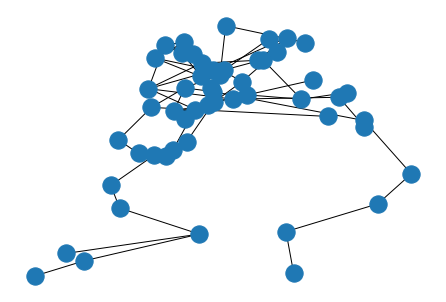

In [11]:
G_vis = G_list[-5]
node_pos = evaluate(model, data_list[-5])
graph_vis(G_vis, node_pos, f'model_-5.png') 

In [12]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
A = to_agraph(G_vis)
A.layout('neato')
A.draw('-5.png')


/opt/conda/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Error: node n0, position (-0.06744841, 0.2486881), expected two doubles
Error: node n22, position (-0.12114087, 0.040030833), expected two doubles
Error: node n36, position (-0.18036142, 0.35609153), expected two doubles
Error: node n40, position (-0.11910941, 0.23892733), expected two doubles
Error: node n1, position (-0.271518, -0.14236857), expected two doubles
Error: node n13, position (-0.16683167, 0.0130901765), expected two doubles
Error: node n32, position (-0.2501976, -0.25907105), expected two doubles
Error: node n2, position (0.15262315, -0.3803688), expected two doubles
Error: node n11, position (0.17110884, -0.5943825), expected two doubles
Error: node n12, position (0.37478584, -0.23737627), expected two doubles
Error: node n3, position (0.45587718, -0.08283261), expected two doubles
Error: node n30, position (0.34121692, 0.19223173), expected two doubles
Error: node n4, position (0.11227367

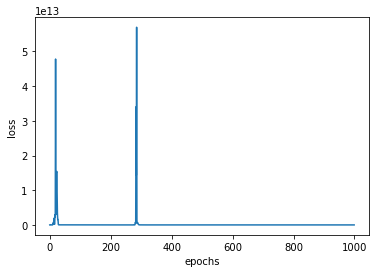

In [174]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_ep[:1000])
plt.show()

tensor([[0.4000, 0.2500, 2.0000],
        [1.2000, 0.0278, 2.0000],
        [0.8000, 0.0625, 2.0000],
        ...,
        [0.6000, 0.1111, 3.0000],
        [1.0000, 0.0400, 3.0000],
        [1.2000, 0.0278, 3.0000]])